In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as keras

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# data preparation for dicty
from prepare_data import *

In [3]:
import sys
sys.path.insert(0, os.getcwd().rsplit('/',1)[0])

import loops_utils

# load unet model
from unet_model import *

In [4]:
%matplotlib inline

In [5]:
image_size = 256

In [6]:
X_train, y_train = prepare_data(image_size, chromosomes=[1,5])
X, y = prepare_data(image_size, chromosomes=[6])
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [7]:
input_img = Input((image_size, image_size, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

weights_path = 'weights/model_unet_256_transfer_learning.h5'

callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
        ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
    ]

model.load_weights('../rao/weights/model_unet_256.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Test score: 0.21660444140434265
Test accuracy: 0.9519805908203125
4/4 [==============================] - 1s 201ms/step


/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:62: RuntimeWarning: divide by zero encountered in log
  raw = np.log(raw)


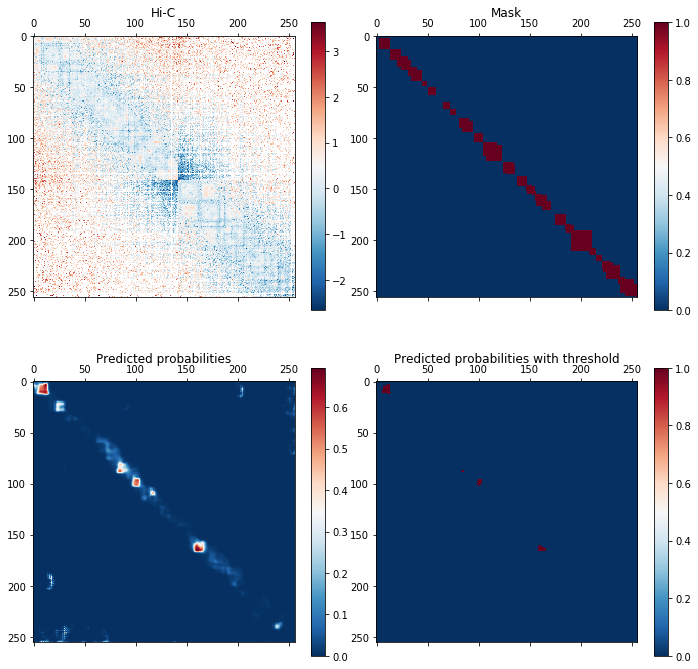

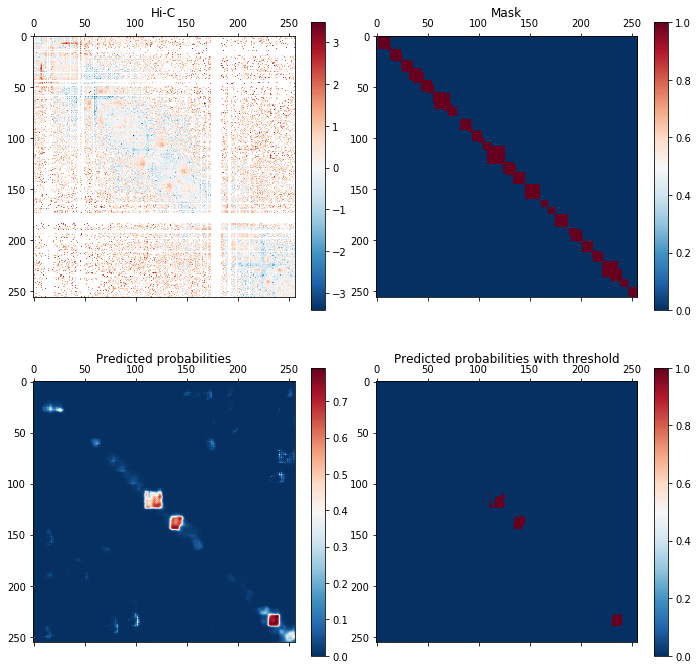

In [8]:
score, acc = model.evaluate(X_test, y_test, verbose=0)
    
print('Test score:', score)
print('Test accuracy:', acc)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

loops_utils.plot_prediction_HiC(X_train[10,:,:,:],
                                y_train[10,:,:,:],
                                preds_train[10,:,:,:],
                                preds_train_t[10,:,:,:],
                                name='pred_transfer_learning_train_10_without_train',
                                image_size=image_size)
    
loops_utils.plot_prediction_HiC(X_test[2,:,:,:],
                                y_test[2,:,:,:],
                                preds_test[2,:,:,:],
                                preds_test_t[2,:,:,:],
                                name='pred_transfer_learning_test_2_without_train',
                                image_size=image_size)

In [9]:
results = model.fit(X_train, y_train, batch_size=1, epochs=100, callbacks=callbacks, 
                        validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 21 samples, validate on 4 samples
Epoch 1/100
21/21 [==============================] - 26s 1s/step - loss: 0.0958 - acc: 0.9612 - val_loss: 0.0787 - val_acc: 0.9599

Epoch 00001: val_loss improved from inf to 0.07866, saving model to weights/model_unet_256_transfer_learning.h5
Epoch 2/100
21/21 [==============================] - 15s 699ms/step - loss: 0.0600 - acc: 0.9725 - val_loss: 0.0668 - val_acc: 0.9687

Epoch 00002: val_loss improved from 0.07866 to 0.06676, saving model to weights/model_unet_256_transfer_learning.h5
Epoch 3/100
21/21 [==============================] - 15s 698ms/step - loss: 0.0547 - acc: 0.9758 - val_loss: 0.0639 - val_acc: 0.9700

Epoch 00003: val_loss improved from 0.06676 to 0.06387, saving model to weights/model_unet_256_transfer_learning.h5
Epoch 4/100
21/21 [==============================] - 15s 706ms/step - loss: 0.0523 - acc: 0.9764 - val_loss: 0.0638 - val_acc: 0.9695

Epoch 00004: val_loss improv

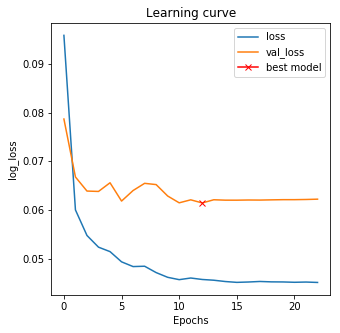

In [10]:
plot_model_scores(results, name='dicty_learning_curve_transfer_learning')

Test score: 0.07163816690444946
Test accuracy: 0.9685440063476562
4/4 [==============================] - 1s 200ms/step


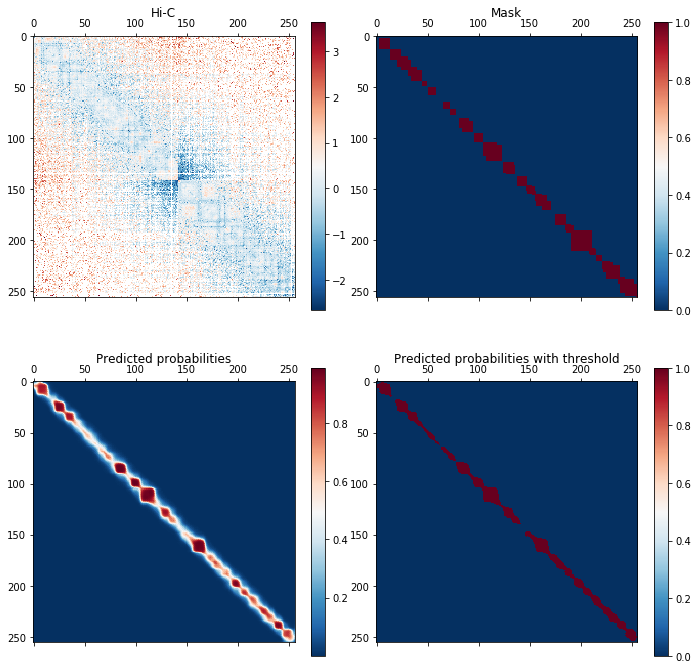

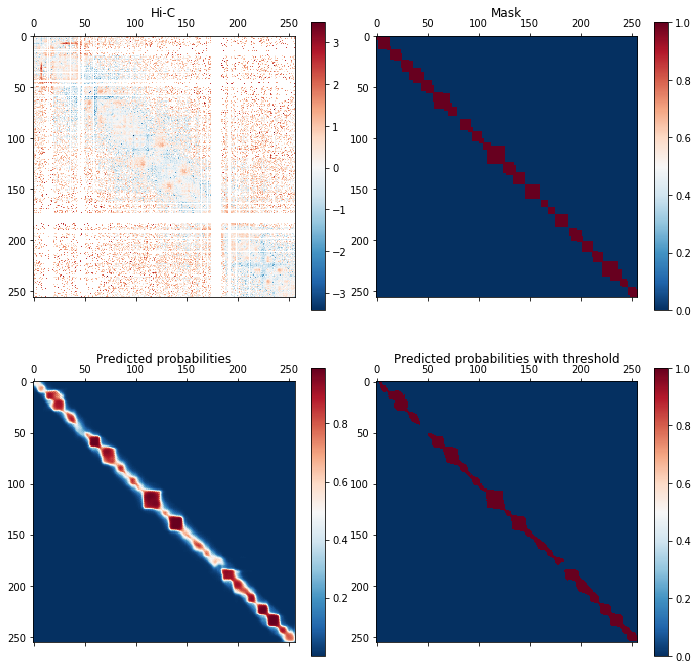

In [11]:
model.load_weights(weights_path)

score, acc = model.evaluate(X_test, y_test, verbose=0)
    
print('Test score:', score)
print('Test accuracy:', acc)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

loops_utils.plot_prediction_HiC(X_train[10,:,:,:],
                                y_train[10,:,:,:],
                                preds_train[10,:,:,:],
                                preds_train_t[10,:,:,:],
                                name='pred_transfer_learning_train_10_with_train',
                                image_size=image_size)
    
loops_utils.plot_prediction_HiC(X_test[2,:,:,:],
                                y_test[2,:,:,:],
                                preds_test[2,:,:,:],
                                preds_test_t[2,:,:,:],
                                name='pred_transfer_learning_tes_2_with_train',
                                image_size=image_size)